# El modelo Ramsey-Cass-Koopmans de crecimiento económico

**Randall Romero Aguilar, PhD**

Este demo se base en uno similar (escrito en Matlab) del libro de texto  <a href="https://mitpress.mit.edu/books/applied-computational-economics-and-finance">Computational Economics and Finance</a> (2001) de Mario Miranda y Paul Fackler.

Para correr este archivo, es necesario contar con la versión Python de CompEcon. Puede instalarse con `pip` usando:

    !pip install compecon --upgrade

<i>Última actualización: 2021-Oct-07</i>
<hr>

## Acerca del modelo de RCK

Se asume que la población (y el trabajo) crecen a la tasa $\frac{\dot{L}}{L}=\xi$, y la productividad del trabajo a la tasa $\frac{\dot{Z}}{Z}=\phi$.

El problema del planificador social se escribe como

\begin{align*}
V(k) &=\max_c \int_{0}^{\infty} \frac{c^{1-\theta}}{1-\theta} e^{-\nu t} \mathrm{d} t \\
\text{sujeto a } \dot{k} &=f(k) - c - (\phi + \xi + \delta) k
\end{align*}

donde $\nu=\rho-(1- \theta)\phi$. El planificador debe decidir cuánto debe la sociedad consumir e invertir, dado el nivel de producción.

La ecuación de Hamilton-Jacobi-Bellman es

\begin{equation*}
\nu V(k) = \max_{c}\left\{u(c) + V'(k)[f(k) - c - (\phi + \xi + \delta) k]\right\}
\end{equation*}

La condición de primer orden es

\begin{align*}
u'(c) &= V'(k) &(\partial . /\partial t)\Rightarrow\qquad u''(c)\dot{c} &= V''(k)\dot{k}
\end{align*}

La condición de la envolvente es

\begin{align*}
\nu V'(k) &= V'(k)[f'(k)-(\phi + \xi + \delta)] + V''(k)\dot{k}\\
V''(k)\dot{k} &= -V'(k)[f'(k)-(\phi + \xi + \delta) - \nu] 
\end{align*}

En el óptimo, debe cumplirse este sistema de ecuaciones diferenciales:

\begin{align*}
\dot{c} &= \tfrac{1}{\rho}[f'(k)-(\phi + \xi + \delta) - \nu] c\\
\dot{k} &=f(k) - c - (\phi + \xi + \delta) k
\end{align*}



* Variable de estado
  - k     stock de capital
* Variable de control
  - c     tasa de consumo
* Parámetros
  - 𝛼    participación del capital
  - 𝛿    tasa de depreciación del capital
  - 𝜃    aversión relativa al riesgo
  - 𝜌    tasa continua de descuento
  - 𝜙    tasa de crecimiento de la productividad del trabajo
  - 𝜉    tasa de crecimiento de la población


## Tareas preliminares

### Importar los paquetes relevantes

$\varphi\xi\nu\phi\theta$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from compecon import BasisChebyshev, OCmodel, ODE

## Crear una clase para representar el modelo

In [2]:
class RamseyCassKoopmans:
    def __init__(self, 𝛼,𝛿,𝜃,𝜌,𝜙,𝜉):
        self.𝛼 = 𝛼   # participación del capital
        self.𝛿 = 𝛿   # tasa de depreciación del capital
        self.𝜃 = 𝜃   # aversión relativa al riesgo
        self.𝜌 = 𝜌   # tasa continua de descuento
        self.𝜙 = 𝜙   # tasa de crecimiento de la productividad del trabajo
        self.𝜉 = 𝜉   # tasa de crecimiento de la población
        self.𝜈 = 𝜌-(1-𝜃)*𝜙 # tasa de descuento ajustada por crecimiento de la productividad
        
        self.f = lambda k: k**𝛼              # función de producción
        self.df = lambda k: 𝛼*k**(𝛼-1)       # producto marginal
        self.u = lambda c: c**(1-𝜃) / (1-𝜃)  # función de utilidad
        self.du = lambda c: c**(-𝜃)          # utilidad marginal  
        self.calcular_estado_estacionario()
        
    @property
    def parámetros(self):
        return self.𝛼, self.𝛿, self.𝜃, self.𝜌, self.𝜙, self.𝜉, self.𝜈
    
    def control(self, k, Vk):
        𝜃 = self.𝜃
        return Vk**(-1/𝜃)

    def reward(self, k, c):
        𝜃 = self.𝜃
        return (1/(1-𝜃) * c**(1-𝜃))

    def transition(self, k, c):
        𝛼,𝛿,𝜃,𝜌,𝜙,𝜉,𝜈 = self.parámetros
        return self.f(k) - (𝜙 + 𝜉 + 𝛿)*k - c
    
    def calcular_estado_estacionario(self):
        𝛼,𝛿,𝜃,𝜌,𝜙,𝜉,𝜈 = self.parámetros
        
        kstar = (𝛼/(𝜙+𝜉+𝛿+𝜈))**(1/(1-𝛼))   # capital
        cstar = self.𝑓(kstar) - (𝜙+𝜉+𝛿) * 𝑘star # consumo
        vstar = self.u(cstar)/𝜈                 # valor
        lstar = self.du(cstar)                 # precio sombra
        ystar = self.f(kstar)                   #producción

        self.estado_estacionario = pd.Series(
            [kstar, cstar, vstar, lstar,ystar],
            index=['Capital', 'Consumo', 'Función valor', 'Precio sombra', 'Producción'])
    
    def resolver(self, n, kmin, kmax):
        # Estructura de aproximación
        basis = BasisChebyshev(n, kmin, kmax, labels=['Capital'])  # base de Chebyshev
        
        # Valores iniciales para iteración
        k = basis.nodes
        basis.y = self.u(self.𝜈 * k)
        
        # Resolver el modelo por colocación
        modelo = OCmodel(basis, self.control, self.reward, self.transition, rho=self.𝜈)
        data = modelo.solve()
        data.rename(columns={'control':'Consumo', 'value':'Valor', 'resid':'Residuo'}, inplace=True)
        data['Producción'] = self.f(data['Capital'])
        data['Tasa de ahorro'] = 1 - data['Consumo']/data['Producción']
        data['Precio sombra'] = modelo.Value(data.index, 1)

        self.solución = data
        self.ode = modelo
        
    def simular(self, k0, T):
        data = self.ode.simulate([k0], T)
        data.rename(columns={'$y_0$': 'Capital', 'control':'Consumo'}, inplace=True)
        data.index.name = 'tiempo'
        data['Producción'] = self.f(data['Capital'])
        self.simulación = data
        
        productividad = pd.Series(np.exp(modelo1.𝜙*data.index.values), index=data.index)
        self.simulación_per_cápita = data.multiply(productividad, axis=0)
        
    def dxdt(self, x):
        k, c = x
        𝛼,𝛿,𝜃,𝜌,𝜙,𝜉,𝜈 = self.parámetros
        cdot = (self.df(k) - (𝛿+𝜙+𝜉+𝜈)) * c / 𝜃
        kdot = self.transition(k, c)
        return np.array([kdot, cdot])
    
    def diagrama_fase(self, ax,klim, clim):
        x0 = [self.estado_estacionario['Capital'], self.estado_estacionario['Consumo']]
        
        problem = ODE(self.dxdt,3,x0)
        problem.rk4(n=1000)
        problem.phase(klim, clim,
              title='ODE Phase Diagram',
              ax=ax,
              animated=0
             )
        𝛼,𝛿,𝜃,𝜌,𝜙,𝜉,𝜈 = self.parámetros
        kvals = np.linspace(*klim, 200)
        ax.plot(self.solución['Capital'], self.solución['Consumo'], color='C0', label='Consumo óptimo')
        ax.plot(kvals, self.f(kvals) - (𝜙 + 𝜉 + 𝛿)*kvals, ls='--',  color='C1', label='$\dot{k}=0$')
        ax.axvline(self.estado_estacionario['Capital'], ls='--',  color='C2', label='$\dot{c}=0$')
        ax.set(title='Diagrama de fase', xlabel='Capital', ylabel='Consumo')
        ax.legend(bbox_to_anchor=(0.85, -0.15), ncol=3)

## Resolver el modelo para un caso particular

### Crear una instancia del modelo

In [3]:
modelo1 = RamseyCassKoopmans(𝛼 = 0.4, 𝛿 = 0.1,𝜃 = 2.0,𝜌 = 0.05,𝜙 = 0.03,𝜉 = 0.02)

### Estado estacionario

In [4]:
modelo1.estado_estacionario

Capital           2.515090
Consumo           1.068913
Función valor   -11.694119
Precio sombra     0.875215
Producción        1.446177
dtype: float64

### Resolver la ecuación Hamilton-Jacobi-Bellman por colocación

In [5]:
n=21
kmin=1
kmax=7
modelo1.resolver(n, kmin, kmax)
modelo1.solución

Solving optimal control model
iter change       time    
------------------------------
   0       6.9e+00    0.0030
   1       5.0e-01    0.0030
   2       1.4e-01    0.0040
   3       1.1e-02    0.0040
   4       5.4e-05    0.0040
   5       1.4e-09    0.0050
Elapsed Time =    0.00 Seconds


,Capital,Valor,Consumo,Residuo,Producción,Tasa de ahorro,Precio sombra
Capital,,,,,,,
1.000000,1.000000,-13.725959,0.675602,6.073624e-08,1.000000,0.324398,2.190877
1.028708,1.028708,-13.663928,0.684992,-5.778167e-08,1.011386,0.322719,2.131222
1.057416,1.057416,-13.603563,0.694260,-3.268908e-08,1.022583,0.321072,2.074700
1.086124,1.086124,-13.544778,0.703411,1.853297e-08,1.033598,0.319454,2.021069
1.114833,1.114833,-13.487495,0.712450,5.010187e-08,1.044441,0.317865,1.970113
...,...,...,...,...,...,...,...
6.885167,6.885167,-9.512590,1.804800,-1.069648e-08,2.163544,0.165813,0.307003
6.913876,6.913876,-9.503796,1.808805,-3.861428e-09,2.167148,0.165352,0.305644
6.942584,6.942584,-9.495041,1.812804,6.643672e-09,2.170743,0.164893,0.304298


## Graficar los resultados

In [6]:
kstar, cstar,vstar, lstar,ystar = modelo1.estado_estacionario # ['Capital', 'Consumo', 'Función valor', 'Precio sombra', 'Producción']
klim = np.array([kmin, kmax])

def indicar_estado_estacionario(ax, xstar, ystar, xlab, ylab):
    xmin = ax.get_xlim()[0]
    ymin = ax.get_ylim()[0]    
    ax.hlines(ystar, xmin, xstar, colors=['gray'], linestyles=['--'])
    ax.vlines(xstar, ymin, ystar, colors=['gray'], linestyles=['--'])
    ax.annotate(ylab, (xmin, ystar))
    ax.annotate(xlab, (xstar, ymin))
    ax.plot(xstar, ystar, '.', ms=20);

### Política óptima

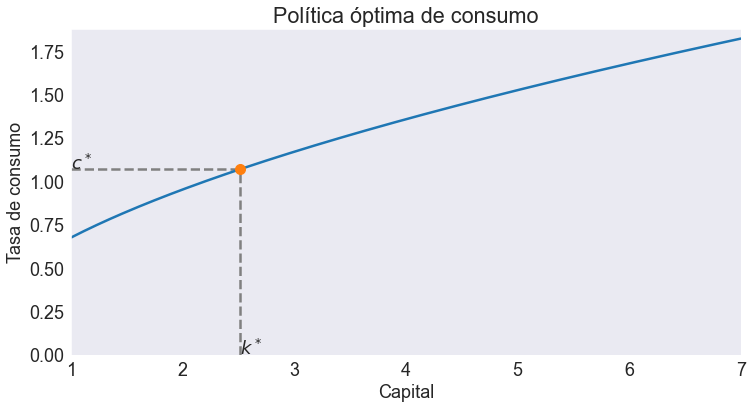

In [7]:
fig1, ax = plt.subplots()
modelo1.solución['Consumo'].plot(ax=ax)
ax.set(title='Política óptima de consumo',
       ylabel='Tasa de consumo',
       xlim=klim)
ax.set_ylim(bottom=0)
indicar_estado_estacionario(ax, kstar, cstar, '$k^*$','$c^*$') 
fig1.savefig('figures/RKC-fig-consumo-capital.pdf', bbox_inches=None)

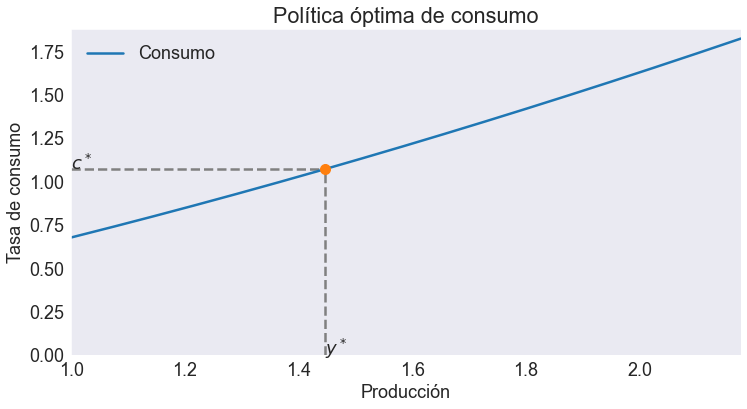

In [8]:
fig2, ax = plt.subplots()
modelo1.solución.plot(x='Producción', y='Consumo', ax=ax)
ax.set(title='Política óptima de consumo',
       xlabel='Producción',
       ylabel='Tasa de consumo',
       xlim=modelo1.f(klim))
ax.set_ylim(bottom=0)
indicar_estado_estacionario(ax, ystar, cstar, '$y^*$','$c^*$') 
fig2.savefig('figures/RKC-fig-consumo-ingreso.pdf', bbox_inches=None)

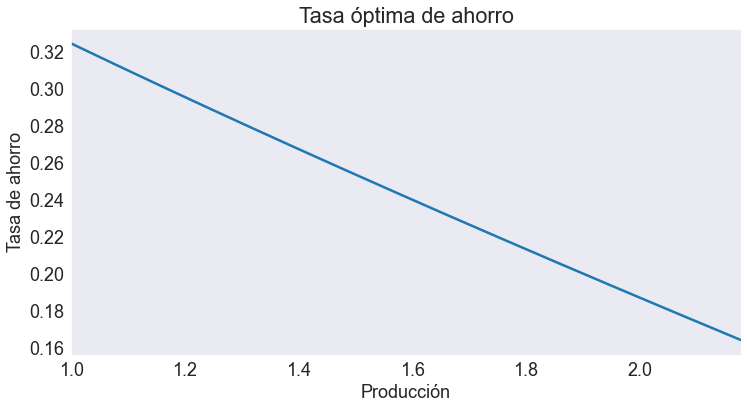

In [9]:
fig3, ax = plt.subplots()
modelo1.solución.plot(ax=ax, x='Producción', y='Tasa de ahorro', legend=None)
ax.set(title='Tasa óptima de ahorro',
       xlabel='Producción',
       ylabel='Tasa de ahorro',
       xlim=modelo1.f(klim));
fig3.savefig('figures/RKC-fig-tasa-ahorro.pdf', bbox_inches=None)

### Función Valor

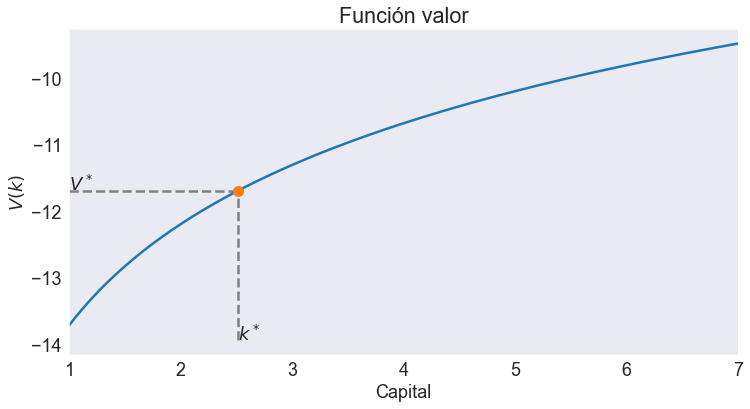

In [10]:
fig4, ax = plt.subplots()
modelo1.solución['Valor'].plot(ax=ax)
ax.set(title='Función valor',
       ylabel='$V(k)$',
       xlim=klim)
indicar_estado_estacionario(ax, kstar, vstar, '$k^*$','$V^*$') 
fig4.savefig('figures/RKC-fig-valor.pdf', bbox_inches=None)

### Precio sombra

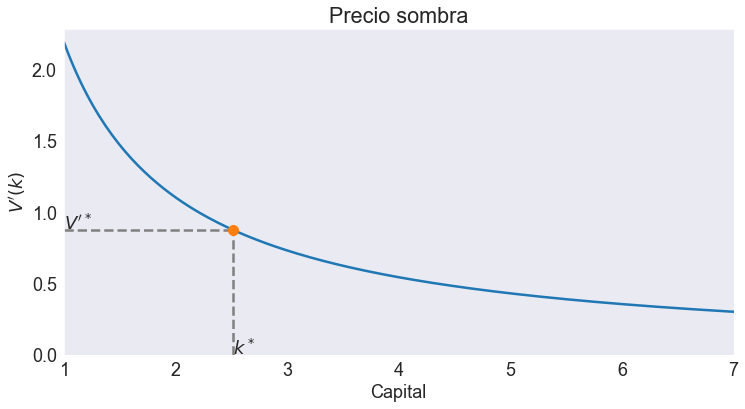

In [11]:
fig5, ax = plt.subplots()
modelo1.solución['Precio sombra'].plot(ax=ax)
ax.set(title='Precio sombra',
       ylabel="$V'(k)$",
       xlim=klim)
ax.set_ylim(bottom=0)
indicar_estado_estacionario(ax, kstar, lstar, '$k^*$',"$V'^*$") 
fig5.savefig('figures/RKC-fig-precio-sombra.pdf', bbox_inches=None)

### Residuo

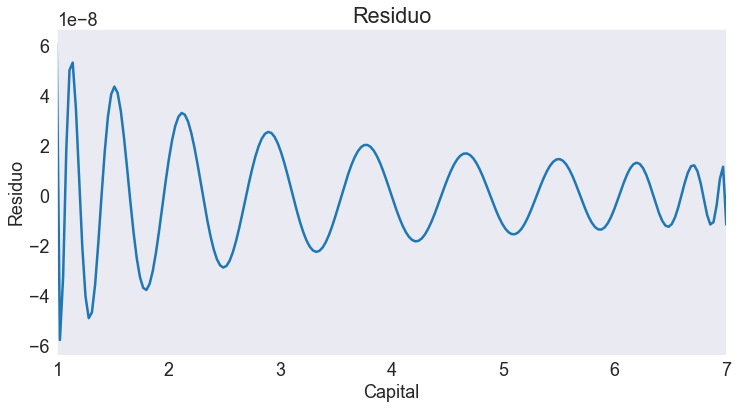

In [12]:
fig6, ax = plt.subplots()
modelo1.solución['Residuo'].plot(ax=ax)
ax.set(title='Residuo',
       ylabel='Residuo',
       xlim=klim);
fig6.savefig('figures/RKC-fig-residuo.pdf', bbox_inches=None)

## Simular el modelo

In [13]:
T = 50
modelo1.simular(kmin, T)
modelo1.simulación

PARAMETER xnames NO LONGER VALID. SET labels= AT OBJECT CREATION


,Capital,Consumo,Producción
tiempo,,,
0.00000,1.000000,0.675602,1.000000
0.05005,1.008711,0.678465,1.003475
0.10010,1.017388,0.681304,1.006919
0.15015,1.026029,0.684121,1.010331
0.20020,1.034636,0.686916,1.013713
...,...,...,...
49.79980,2.513111,1.068486,1.445722
49.84985,2.513124,1.068489,1.445725
49.89990,2.513137,1.068492,1.445728


### Graficar las sendas simuladas

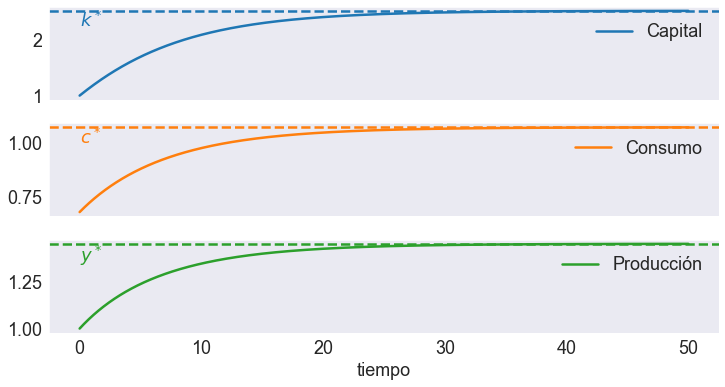

In [14]:
fig7, axs = plt.subplots(3, 1, sharex=True)
modelo1.simulación.plot(ax=axs, subplots=True)
ax.set(title='Simulated Capital Stock and Rate of Consumption',
       xlabel='Time',
       ylabel='Quantity',
       xlim=[0, T])

i = 0
for ax, xstar, lab in zip(axs.T, [kstar,cstar,ystar], ['$k^*$', '$c^*$', '$y^*$']):
    ax.axhline(xstar, ls='--', c=f'C{i}')
    ax.annotate(lab, (0, xstar), color=f'C{i}', va='top')
    i+=1
fig7.savefig('figures/RKC-fig-simulación.pdf', bbox_inches=None)

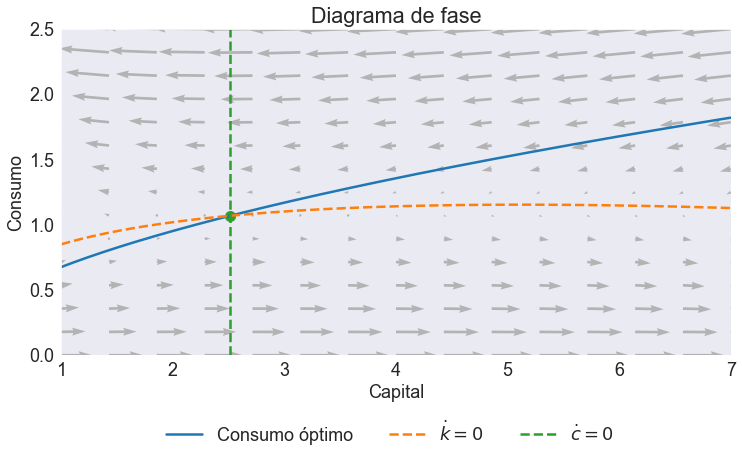

In [15]:
fig8,ax = plt.subplots()
modelo1.diagrama_fase(ax,klim=[1,7], clim=[0,2.5])
fig8.savefig('figures/RKC-fig-diagrama-fase.pdf', bbox_inches=None)

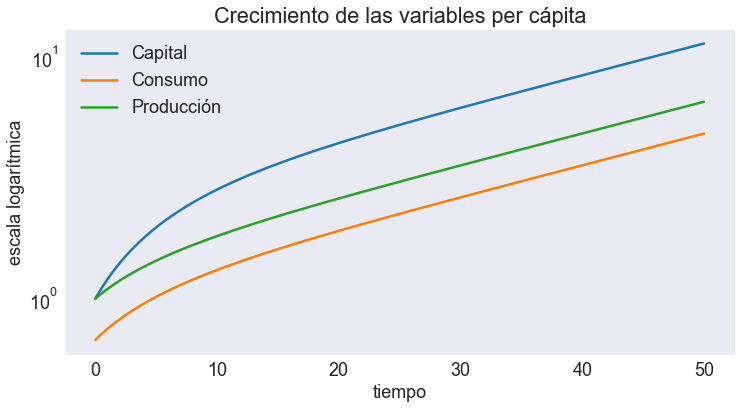

In [16]:
fig9, ax= plt.subplots()
modelo1.simulación_per_cápita.plot(ax=ax)
ax.set(title='Crecimiento de las variables per cápita',
       ylabel='escala logarítmica',
       yscale='log')
fig9.savefig('figures/RKC-fig-crecimiento-percápita.pdf', bbox_inches=None)